In [1]:
# Reload modules automatically
# https://ipython.readthedocs.io/en/stable/config/extensions/autoreload.html
%load_ext autoreload
%autoreload 2

In [2]:
from collections import Counter
import math
from typing import List

import numpy as np
from scipy.stats import multivariate_normal
import matplotlib.pyplot as plt
import torch
from tqdm import tqdm

from common import CSBM

In [3]:
def likelihood(n_id, n_cls):
    """Return likelihood of node n_id being of class n_cls."""
    likelihood = multivariate_normal.pdf(X[n_id,:], mean=(2*n_cls - 1)*mu, cov=cov)
    for i in range(len(y)):
        if i != n_id:
            if y[i] == n_cls:
                likelihood *= p if A[n_id, i] == 1 else 1-p
            else:
                likelihood *= q if A[n_id, i] == 1 else 1-q
    return likelihood

def loglikelihood(n_id, n_cls):
    """Return log-likelihood of node n_id being of class n_cls."""
    likelihood = math.log(multivariate_normal.pdf(X[n_id,:], mean=(2*n_cls - 1)*mu, cov=cov))
    for i in range(len(y)):
        if i != n_id:
            if y[i] == n_cls:
                likelihood += math.log(p) if A[n_id, i] == 1 else math.log(1-p)
            else: 
                likelihood += math.log(q) if A[n_id, i] == 1 else math.log(1-q)
    return likelihood

def structure_loglikelihood(n_id, n_cls):
    """Return log-likelihood of node n_id being of class n_cls."""
    likelihood = 0
    for i in range(len(y)):
        if i != n_id:
            if y[i] == n_cls:
                likelihood += math.log(p) if A[n_id, i] == 1 else math.log(1-p)
            else: 
                likelihood += math.log(q) if A[n_id, i] == 1 else math.log(1-q)
    return likelihood

def sample(seed = 0):
    """Sample y~Bin(1/2) and X,A ~ CSBM. Return X, A, y."""
    np.random.seed(seed)
    # Sample y
    y = np.random.randint(0,2,size=n)
    n_class1 = sum(y)
    n_class0 = len(y) - n_class1 
    # Sample X|y
    X_0 = np.random.multivariate_normal(-mu, cov, n_class0).astype(np.float32)
    X_1 = np.random.multivariate_normal(mu, cov, n_class1).astype(np.float32)
    X = torch.zeros((n,d))
    X[y == 0, :] = torch.tensor(X_0)
    X[y == 1, :] = torch.tensor(X_1)
    #print(sum(torch.eq(torch.tensor(y), X[:,0] > 0)))
    # Sample A|y
    edge_prob = np.zeros((n,n))
    for i in range(n):
        for j in range(i+1, n):
            if y[i] == y[j]:
                edge_prob[i,j] = p
            else:
                edge_prob[i,j] = q
    A = np.random.binomial(1, edge_prob)
    A += A.T
    return X, A, y

## Generate Data

In [11]:
# X, A ~ CSBM(n, p, q, mu, cov)
n = 1000
avg_intra_degree = 1.5 * 2 # intra_edges_per_node * 2
avg_inter_degree = 0.5 * 2
p = avg_intra_degree * 2 / (n - 1)
q = avg_inter_degree * 2 / (n - 1)
K = 0.5 # Defines distance between means of the gaußians in sigma-units
sigma = 0.1
d = round(n / math.log(n)**2)
#d = 1
mu = np.array([K*sigma / (2 * d**0.5) for i in range(d)], dtype=np.float32)
cov = sigma**2 * np.identity(d, dtype=np.float32)
#mu = np.array([1 for i in range(d)])
X, A, y = sample(seed=0)
print(f"Dim: {d}")

Dim: 21


In [12]:
model = CSBM(p, q, mu, cov)
X_, A_, y_ = model.sample(1000, seed = 0)
model.check_separabilities(X_, A_, y_)

Feature Separability:
n_corr: 624
n_wrong: 376
Structure Separability:
n_corr: 820
n_wrong: 180
Likelihood Separability:
n_corr: 839
n_wrong: 161


In [16]:
# Abbe 2014 community recovery threshold
# (math.sqrt(p) - math.sqrt(q))*math.sqrt(n / math.log(n))

2.7854442345000603

## Nodes Violating Bayes Criterion after Generation

In [8]:
model.check_separabilities(X, A, y)

Feature Separability:
n_corr: 624
n_wrong: 376
Structure Separability:
n_corr: 820
n_wrong: 180
Likelihood Separability:
n_corr: 839
n_wrong: 161


## Degree Distribution

(15.0, 50.0)

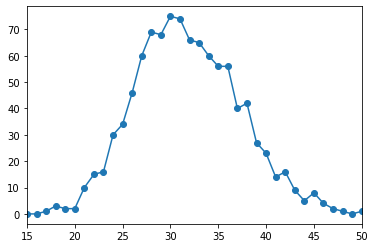

In [21]:
deg = np.sum(A, axis=1)
max_deg = np.max(deg)
c = Counter(deg)
ordered_c = [c[i] if i in c else 0 for i in range(max_deg+1)]
fig, axs = plt.subplots(1, 1)
axs.plot(range(len(ordered_c)), ordered_c, 'o-')
axs.set_xlim(left=15, right=50)


100%|██████████| 1000/1000 [00:42<00:00, 23.49it/s]


(0.0, 15.0)

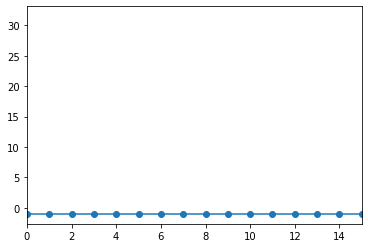

In [22]:
# Evaluate robustness to edge insertions of total likelihood
def has_correct_bayes(i):
    """Return true if bayes classifier classifies node correctly."""
    likelihood_corr = loglikelihood(i, y[i])
    likelihood_wrong = loglikelihood(i, -(y[i]-1))
    if likelihood_corr > likelihood_wrong:
        return True
    return False

def add_adversarial_edge(i):
    """Add adversarial edge to matrix A. Return new neighbour idx."""
    if y[i] == 0:
        pot_neighbours = idx_1
    else:
        pot_neighbours = idx_0
    # Add an edge to a node of different class
    for j in pot_neighbours:
        if A[i,j] == 1:
            continue
        else:
            A[i,j] = 1
            A[j,i] = 1
            return j
    assert(False)

def remove_edges_from_node(node_id, neighbour_ids: List):
    """Removes edges between node_id and nodes in neighbour_ids list."""
    for j in neighbour_ids:
        A[node_id, j] = 0
        A[j, node_id] = 0

# Count for each degree, how much edges can be inserted on average until 
# bayes-classifier changes prediction
c_degree = Counter()
c_robust = Counter()
idx_0 = torch.tensor(range(n))[y == 0]
idx_1 = torch.tensor(range(n))[y == 1]
for i in tqdm(range(n)):
    if not has_correct_bayes(i):
        # Only consider nodes who have correct bayes decision
        continue
    inserted_idx = []
    # Incrementally add adversarial edges until bayes decision flips
    broke_classifier = False
    for robustness_count in range(0, int(n/2)):
        inserted_idx.append(add_adversarial_edge(i))
        if not has_correct_bayes(i):
            remove_edges_from_node(i, inserted_idx)
            c_robust[deg[i]] += robustness_count
            c_degree[deg[i]] += 1
            broke_classifier = True
            break
    assert broke_classifier
# Average robustness count
avg_robust = {}
c = Counter(deg)
for degree in c:
    if c_degree[degree] > 0: 
        avg_robust[degree] = c_robust[degree] / c_degree[degree]

# Plot
max_deg = np.max(deg)
ordered_c = [avg_robust[i] if i in avg_robust else -1 for i in range(max_deg+1)]
fig, axs = plt.subplots(1, 1)
axs.plot(range(len(ordered_c)), ordered_c, 'o-')
axs.set_xlim(left=0, right=15)

(15.0, 50.0)

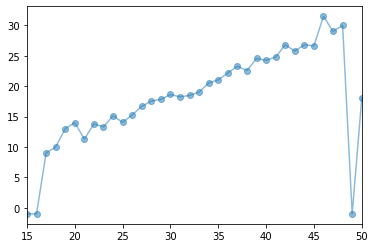

In [25]:
fig, axs = plt.subplots(1, 1)
axs.plot(range(len(ordered_c)), ordered_c, 'o-', alpha=0.5)
axs.set_xlim(left=15, right=50)

In [26]:
# Count maximum robustness per node
max_robust = {}
idx_0 = torch.tensor(range(n))[y == 0]
idx_1 = torch.tensor(range(n))[y == 1]
for i in tqdm(range(n)):
    if not has_correct_bayes(i):
        # Only consider nodes who have correct bayes decision
        continue
    inserted_idx = []
    # Incrementally add adversarial edges until bayes decision flips
    broke_classifier = False
    for robustness_count in range(0, int(n/2)):
        inserted_idx.append(add_adversarial_edge(i))
        if not has_correct_bayes(i):
            remove_edges_from_node(i, inserted_idx)
            if deg[i] not in max_robust:
                max_robust[deg[i]] = robustness_count
            else:
                if robustness_count > max_robust[deg[i]]:
                    max_robust[deg[i]] = robustness_count
            broke_classifier = True
            break
    assert broke_classifier
print(max_robust)

100%|██████████| 1000/1000 [00:41<00:00, 23.84it/s]

{35: 31, 20: 14, 30: 27, 38: 31, 24: 21, 26: 23, 31: 26, 36: 31, 29: 27, 32: 30, 28: 26, 33: 29, 18: 12, 40: 33, 22: 19, 25: 22, 23: 19, 34: 32, 44: 32, 37: 33, 27: 25, 42: 34, 43: 37, 41: 39, 39: 34, 21: 19, 46: 37, 45: 34, 48: 30, 47: 31, 17: 9, 50: 18, 19: 15}


In [ ]:
max_deg = np.max(deg)
ordered_c = [avg_robust[i] if i in avg_robust else -1 for i in range(max_deg+1)]

In [61]:
X, A, y = sample(seed=0)
i = 0
has_correct_bayes(i)
print(np.sum(A[i,:]))
print(np.sum(A[i,y==0]))
print(np.sum(A[i,y==1]))
print(y[i])
print(loglikelihood(i, y[i]))
print(loglikelihood(i, -(y[i] - 1)))

j = add_adversarial_edge(i)
print(j, y[j])
print(np.sum(A[i,:]))
print(np.sum(A[i,y==0]))
print(np.sum(A[i,y==1]))
print(loglikelihood(i, y[i]))
print(loglikelihood(i, -(y[i] - 1)))

j = add_adversarial_edge(i)
print(j, y[j])
print(np.sum(A[i,:]))
print(np.sum(A[i,y==0]))
print(np.sum(A[i,y==1]))
print(loglikelihood(i, y[i]))
print(loglikelihood(i, -(y[i] - 1)))

j = add_adversarial_edge(i)
print(j, y[j])
print(np.sum(A[i,:]))
print(np.sum(A[i,y==0]))
print(np.sum(A[i,y==1]))
print(loglikelihood(i, y[i]))
print(loglikelihood(i, -(y[i] - 1)))

j = add_adversarial_edge(i)
print(j, y[j])
print(np.sum(A[i,:]))
print(np.sum(A[i,y==0]))
print(np.sum(A[i,y==1]))
print(loglikelihood(i, y[i]))
print(loglikelihood(i, -(y[i] - 1)))

j = add_adversarial_edge(i)
print(j, y[j])
print(np.sum(A[i,:]))
print(np.sum(A[i,y==0]))
print(np.sum(A[i,y==1]))
print(loglikelihood(i, y[i]))
print(loglikelihood(i, -(y[i] - 1)))

j = add_adversarial_edge(i)
print(j, y[j])
print(np.sum(A[i,:]))
print(np.sum(A[i,y==0]))
print(np.sum(A[i,y==1]))
print(loglikelihood(i, y[i]))
print(loglikelihood(i, -(y[i] - 1)))

j = add_adversarial_edge(i)
print(j, y[j])
print(np.sum(A[i,:]))
print(np.sum(A[i,y==0]))
print(np.sum(A[i,y==1]))
print(loglikelihood(i, y[i]))
print(loglikelihood(i, -(y[i] - 1)))

j = add_adversarial_edge(i)
print(j, y[j])
print(np.sum(A[i,:]))
print(np.sum(A[i,y==0]))
print(np.sum(A[i,y==1]))
print(loglikelihood(i, y[i]))
print(loglikelihood(i, -(y[i] - 1)))

j = add_adversarial_edge(i)
print(j, y[j])
print(np.sum(A[i,:]))
print(np.sum(A[i,y==0]))
print(np.sum(A[i,y==1]))
print(loglikelihood(i, y[i]))
print(loglikelihood(i, -(y[i] - 1)))

6
6
0
0
-15.992659153707786
-22.790973858434004
tensor(1) 1
7
6
1
-22.20426274310961
-27.899945053251024
tensor(2) 1
8
6
2
-28.41586633251149
-33.008916248068154
tensor(4) 1
9
6
3
-34.62746992191338
-38.1178874428853
tensor(5) 1
10
6
4
-40.8390735113152
-43.22685863770247
tensor(6) 1
11
6
5
-47.05067710071714
-48.335829832519515
tensor(7) 1
12
6
6
-53.2622806901191
-53.44480102733658
tensor(8) 1
13
6
7
-59.47388427952096
-58.55377222215369
tensor(9) 1
14
6
8
-65.68548786892285
-63.66274341697084
tensor(10) 1
15
6
9
-71.89709145832448
-68.77171461178793


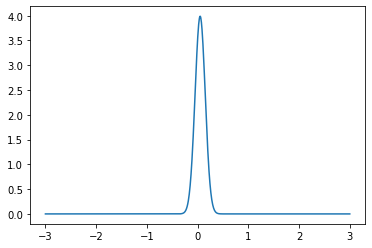

In [95]:
fig, ax = plt.subplots(1, 1)
x = np.linspace(start=-3, stop=3, num=1000)
ax.plot(x, multivariate_normal.pdf(x, mean=(2*y[i] - 1)*mu, cov=cov))

In [12]:
# Sanity check Adjacency Matrix 
n_intra_nodes = 0
n_inter_nodes = 0
n_intra_edges = 0
n_inter_edges = 0
for i in range(n):
    for j in range(i+1, n):
        if y[i] == y[j]:
            n_intra_nodes += 1
            if A[i,j] == 1:
                 n_intra_edges += 1
        else:
            n_inter_nodes += 1
            if A[i,j] == 1:
                 n_inter_edges += 1
print(f"Number of edges: {n_intra_edges + n_inter_edges}")
print(f"Average #edges per node: {(n_intra_edges + n_inter_edges)/n}")
print(f"Average intra-connections: {n_intra_edges / n}")
print(f"Average inter-connections: {n_inter_edges / n}")

Number of edges: 3995
Average #edges per node: 3.995
Average intra-connections: 2.954
Average inter-connections: 1.041
